# Multilevel regression and poststratification 



In [91]:
# Import analysis packages
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [82]:
# Read the simulated population dataset from github Dataset repository
popn = pd.read_csv("https://raw.githubusercontent.com/HPCurtis/Datasets/main/MMRPpopn.csv")
popn = popn.drop(columns='Unnamed: 0')

In [84]:
popn.loc[popn['uni'] == 1,];

In [76]:
# Read the simulated dataset from github Dataset repository
# https://github.com/HPCurtis/Datasets/tree/main
df = pd.read_csv("https://raw.githubusercontent.com/HPCurtis/Datasets/main/MMRP.csv")
# Drop repeated column.
df = df.drop(columns='Unnamed: 0')
df.head(2)

,ID,major,gender,uni,mathsanxiety_t1,mathsanxiety_t2_Z_0,mathsanxiety_t2_Z_1,Z,Z_cond_prob
0,216948,4,1,1,30.525949,42.130163,22.661971,0,0.5
1,9386,5,1,1,38.883424,38.237744,29.880371,1,0.5


In [47]:
# Generate index variables for vectoristion of pymc model
genderID = df.gender.values - 1
majorID = df.major.values - 1 
# Int values for the shape of the multilevel model 
Ng = int(max(df.gender))
Nm = int(max(df.major))

In [61]:
# Define Pymc Mmdel
with pm.Model() as mmrpm:
    # Priors
    # Model implemeted with Brms defaults
    alpha = pm.StudentT('alpha', nu = 3, mu = 30.2 , sigma = 11.2)
    sigma = pm.HalfStudentT('sigma', nu = 3, sigma = 11.4)
    
    # Hyperpriors
    sd1 = pm.HalfStudentT('genderSD', nu = 3, sigma = 11.4)
    sd2 = pm.HalfStudentT('majorSD', nu = 3, sigma = 11.4)
    
    # Random intercepts.
    z1 = pm.Normal('gender', 0, sd1, shape = Ng)
    z2 = pm.Normal('major', 0, sd2, shape = Nm)
    
    # likelihood
    mu = pm.Normal.dist(mu = alpha + z1[genderID] + z2[majorID], sigma = sigma)
    y = pm.Truncated("y", mu, lower = 10, upper = 50, observed = df['mathsanxiety_t1'])

In [73]:
with mmrpm:
    # Sample using pymc sampler as numpyro call has issue with aesara backend
    # For truncated Normal (see, 
    # https://discourse.pymc.io/t/jax-sampling-error-with-truncatednormal-distribution/10656/2)
    
    # Step size same as Brms example
    step = pm.NUTS(target_accept=.99)
    idata = pm.sample(step=step, )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, genderSD, majorSD, gender, major]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.


In [74]:
# Ooutput summary of model parameters.
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,27.756,5.922,16.339,39.306,0.205,0.147,909.0,784.0,1.01
gender[0],4.414,5.505,-6.260,14.593,0.188,0.134,961.0,856.0,1.00
gender[1],-9.358,5.601,-20.449,0.796,0.195,0.142,932.0,840.0,1.00
gender[2],2.723,5.749,-8.450,13.150,0.188,0.135,1030.0,947.0,1.00
major[0],-6.394,3.394,-12.412,-0.362,0.105,0.076,1254.0,1529.0,1.00
major[1],-1.469,3.470,-7.967,4.772,0.109,0.089,1220.0,1200.0,1.01
major[2],-0.304,3.012,-5.408,5.639,0.107,0.087,954.0,963.0,1.01
major[3],3.230,3.068,-2.344,8.746,0.107,0.090,1003.0,945.0,1.00
major[4],3.852,2.959,-1.432,9.301,0.109,0.089,916.0,844.0,1.00
sigma,9.801,0.685,8.633,11.147,0.015,0.011,2232.0,2078.0,1.00


# Plot trace plots 

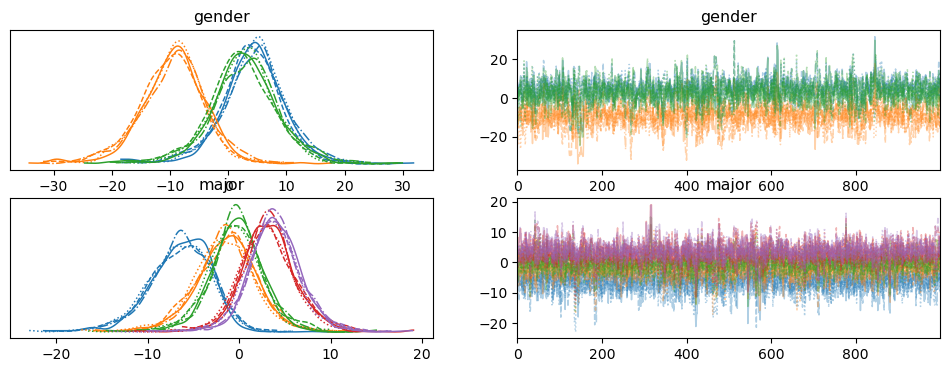

In [65]:
az.plot_trace(idata, var_names = ['gender', 'major']);

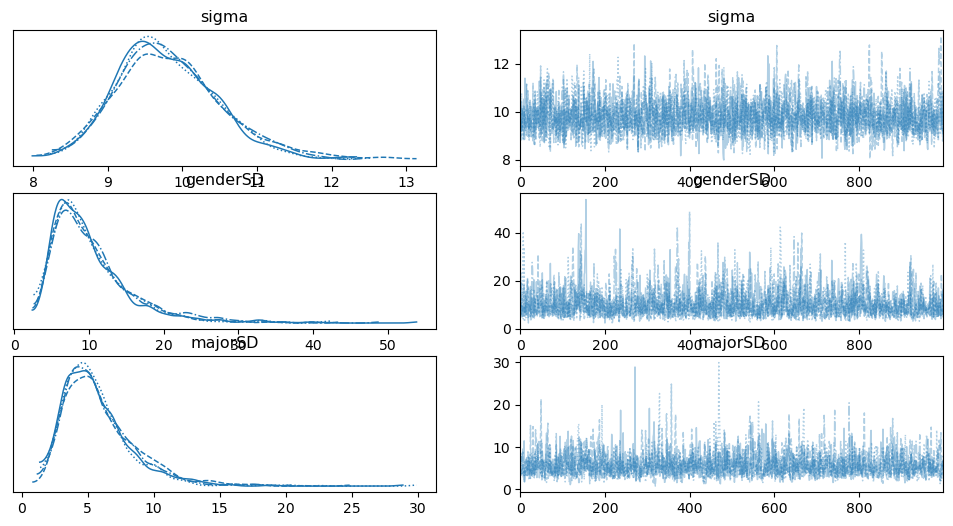

In [66]:
az.plot_trace(idata, var_names = ['sigma', 'genderSD', 'majorSD']);

In [68]:
with mmrpm:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y]


# Plot Posterior predictive checks for whole dataset

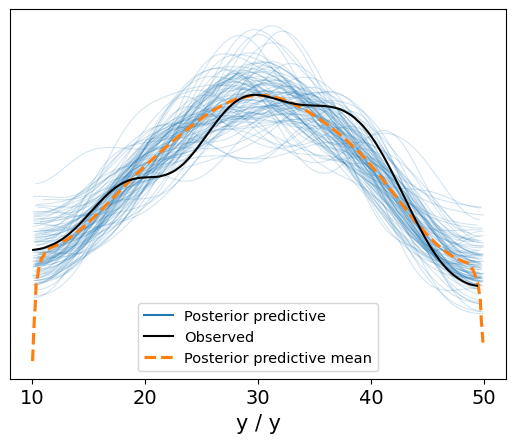

In [70]:
az.plot_ppc(idata, num_pp_samples=100);

# References

Kennedy, L., & Gelman, A. (2021). Know your population and know your model: Using model-based regression and poststratification to generalize findings beyond the observed sample. Psychological methods, 26(5), 547.